# ***Real-Time Twitter Sentiment Analysis***

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import ipywidgets as widgets
from IPython.display import display
import re
import zipfile
import requests
from io import BytesIO

In [17]:
url = "https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip"
response = requests.get(url)
zip_file = zipfile.ZipFile(BytesIO(response.content))
csv_file = zip_file.open('training.1600000.processed.noemoticon.csv')
tweets = pd.read_csv(csv_file, encoding='latin-1', header=None)
tweets.columns = ['polarity', 'id', 'date', 'query', 'user', 'text']
tweets = tweets[['text', 'polarity']]
tweets.head()

,text,polarity
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [18]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

tweets['text'] = tweets['text'].apply(preprocess_text)
tweets['polarity'] = tweets['polarity'].map({4: 1, 2: 0, 0: -1})

In [19]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(tweets['text'])
y = tweets['polarity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [21]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.766115625
Confusion Matrix:
 [[124349  35145]
 [ 39698 120808]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.76      0.78      0.77    159494
           1       0.77      0.75      0.76    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



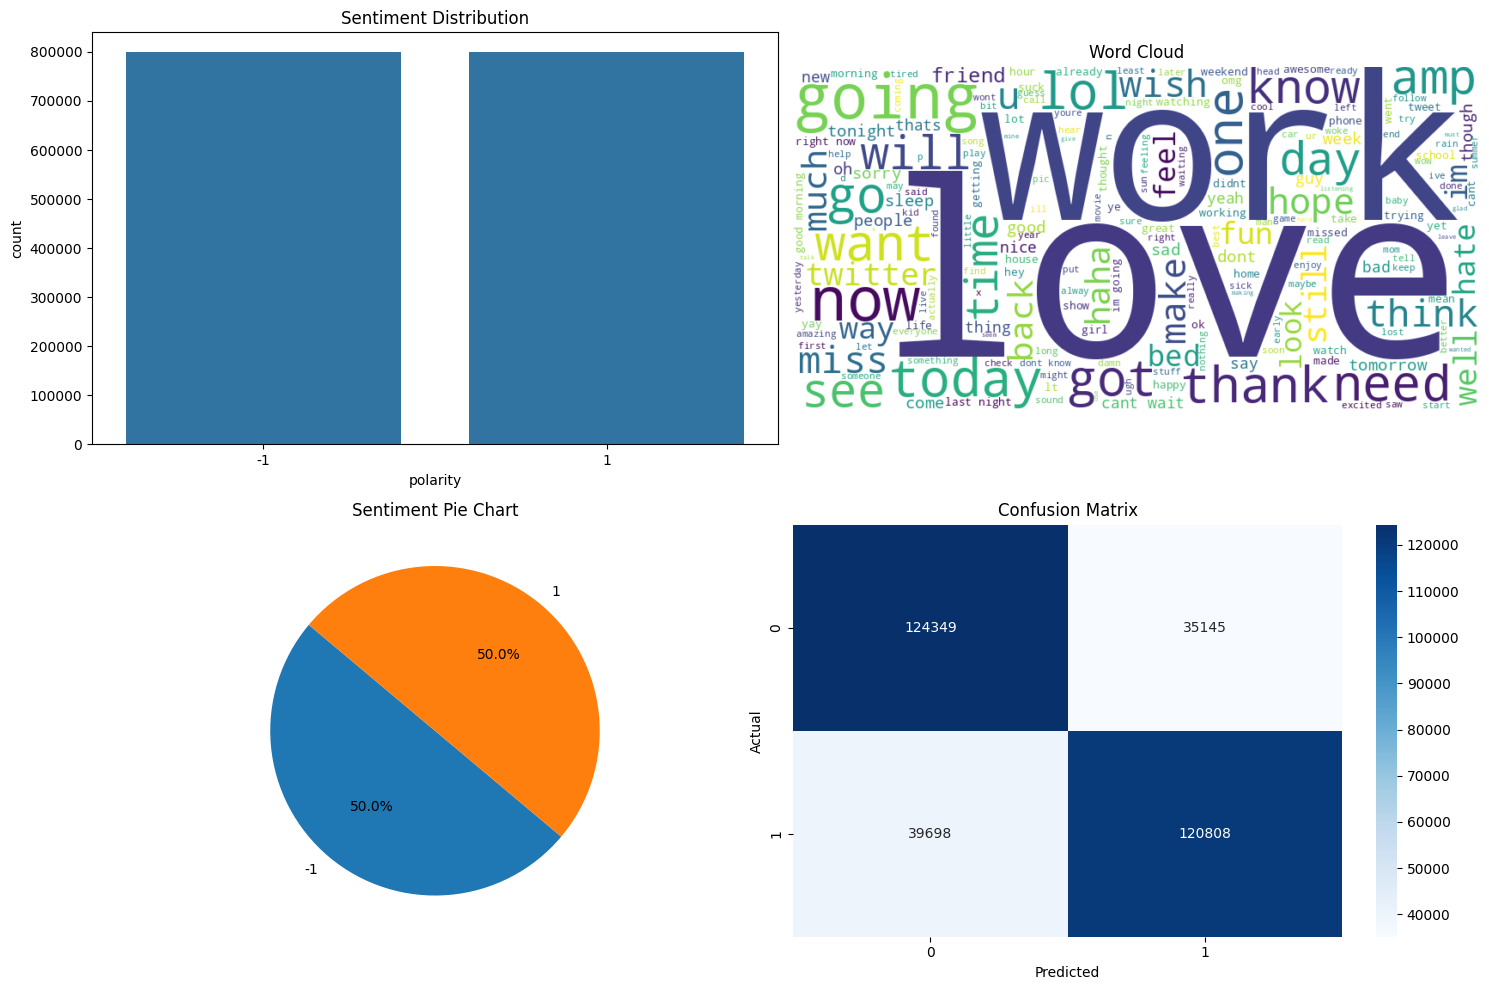

In [22]:
def create_dashboard():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Sentiment Distribution
    sns.countplot(x='polarity', data=tweets, ax=axes[0, 0])
    axes[0, 0].set_title('Sentiment Distribution')

    # Word Cloud
    text = ' '.join(tweets['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    axes[0, 1].imshow(wordcloud, interpolation='bilinear')
    axes[0, 1].axis('off')
    axes[0, 1].set_title('Word Cloud')

    # Sentiment Pie Chart
    sentiment_counts = tweets['polarity'].value_counts()
    # Check the unique values in the 'polarity' column
    labels = sentiment_counts.index.tolist()
    axes[1, 0].pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=140) #Use the labels derived from the sentiment_counts variable
    axes[1, 0].set_title('Sentiment Pie Chart')

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted')
    axes[1, 1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

create_dashboard()

In [23]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Predict sentiment function
def predict_sentiment(text):
    text = preprocess_text(text)
    text_vectorized = vectorizer.transform([text])
    prediction = model.predict(text_vectorized)
    sentiment = 'Positive' if prediction == 1 else 'Neutral' if prediction == 0 else 'Negative'
    return sentiment

# Function to handle input from the user and display the sentiment
def on_text_submit(change):
    with output:
        clear_output()  # Clear previous output
        user_text = tweet_input.value  # Get the input text
        sentiment = predict_sentiment(user_text)  # Predict the sentiment
        sentiment_label.value = f"Sentiment: {sentiment}"  # Update sentiment label

        # Display corresponding image based on sentiment
        if sentiment == 'Positive':
            img = plt.imread('/content/positive.png')
        elif sentiment == 'Neutral':
            img = plt.imread('/content/neutral.png')
        else:
            img = plt.imread('/content/negative.png')

        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Adjust the height of the output widget based on the image size
        output.layout.height = 'auto'

# Function to handle clicking on a sample tweet
def on_tweet_click(b):
    tweet_input.value = b.description  # Set the clicked tweet in the input field

# Function to show random sample tweets from the dataset with clickable buttons
def show_sample_tweets(b):
    with sample_output:
        clear_output()  # Clear previous output
        sample_tweets = tweets.sample(5)
        tweet_buttons = []
        for _, row in sample_tweets.iterrows():
            tweet_text = row['text']
            button = widgets.Button(
                description=tweet_text,
                layout=widgets.Layout(width='100%', height='auto')
            )
            button.on_click(on_tweet_click)
            tweet_buttons.append(button)

        tweet_box = widgets.VBox(tweet_buttons)
        display(tweet_box)

# Input text box for entering tweets
tweet_input = widgets.Text(
    value='',
    placeholder='Type a tweet...',
    description='Tweet:',
    layout=widgets.Layout(width='70%', height='30px'),  # Adjust the size for better appearance
    style={'description_width': 'initial'}
)

# Button to analyze the tweet
analyze_button = widgets.Button(
    description="Analyze Sentiment",
    button_style='info',  # Apply some color to the button for better visual appeal
    layout=widgets.Layout(width='100%', height='40px')
)

# Label to display the result of the sentiment analysis
sentiment_label = widgets.Label(
    value="",
    layout=widgets.Layout(width='100%', height='40px', font_size='200px')
)
# Output area to show the sentiment image
output = widgets.Output(layout=widgets.Layout(width='100%', height='auto'))

# Button to display sample tweets
sample_button = widgets.Button(
    description="Show Sample Tweets",
    button_style='primary',
    layout=widgets.Layout(width='100%', height='40px')
)

# Output area for displaying sample tweets
sample_output = widgets.Output(layout=widgets.Layout(width='100%', height='auto'))

# Event handling for buttons
analyze_button.on_click(lambda b: on_text_submit(None))  # Call the sentiment analysis function on click
sample_button.on_click(show_sample_tweets)

# Adding a container (window) to visually encapsulate the UI elements
ui_container = widgets.Box(
    [
        widgets.HTML(value="<h2 style='text-align:center;'>Real-Time Twitter Sentiment Analysis</h2>"),
        tweet_input,
        widgets.HBox([analyze_button], layout=widgets.Layout(justify_content='center')),
        widgets.HBox([sentiment_label], layout=widgets.Layout(justify_content='center')),
        widgets.HBox([output], layout=widgets.Layout(justify_content='center')),
        widgets.HBox([sample_button], layout=widgets.Layout(justify_content='center')),
        sample_output
    ],
    layout=widgets.Layout(
        display='flex',
        flex_flow='column',
        align_items='center',
        border='solid 1px #ccc',
        padding='20px',
        width='90%'
    )
)

# Display the UI inside the container
display(ui_container)

Box(children=(HTML(value="<h2 style='text-align:center;'>Real-Time Twitter Sentiment Analysis</h2>"), Text(val…

# ***HAPPY COADING!!***